# Example of segmentation of the optic disc and cup using the dual and cascade architectures

In [1]:
import albumentations as A
import cv2 as cv
import os
import matplotlib.pyplot as plt
import pandas as pd
import torch
from albumentations.pytorch import ToTensorV2

from modules import *
from networks import *
from training import *
from ROI import CenterNet, detect_roi, preprocess_centernet_input

### Step 1: Region of Interest detection with CenterNet

In [2]:
images_dir = '../data/ImagesForSegmentation'
image_paths = [os.path.join(images_dir, f) for f in os.listdir(images_dir)]
image_paths = list(filter(lambda x: os.path.isfile(x), image_paths))
image_paths

['../data/ImagesForSegmentation\\1082715_T_1082715_20151212_111331_Color_L_01.jpg',
 '../data/ImagesForSegmentation\\1085032_T_1085032_20151219_113812_Color_R_01.jpg',
 '../data/ImagesForSegmentation\\1107477_T_1107477_20160225_122700_Color_L_01.jpg',
 '../data/ImagesForSegmentation\\1119879_T_1119879_20160328_111556_Color_R_01.jpg',
 '../data/ImagesForSegmentation\\1120696_T_1120696_20160330_104233_Color_L_01.jpg',
 '../data/ImagesForSegmentation\\1205301_T_1205301_20161027_134554_Color_R_01.jpg',
 '../data/ImagesForSegmentation\\184303_T_184303_20170217_112031_Color_R_01.jpg',
 '../data/ImagesForSegmentation\\28877_T_28877_20151224_095119_Color_R_01.jpg',
 '../data/ImagesForSegmentation\\535502_T_535502_20170124_155432_Color_L_01.jpg',
 '../data/ImagesForSegmentation\\833620_T_833620_20160128_102311_Color_R_01.jpg']

In [3]:
MODEL_PATH = '../models/roi/centernet.pth'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CenterNet(n_classes=1, scale=4, base='resnet18', custom=True)
state_dict = torch.load(MODEL_PATH, map_location=DEVICE)
model.load_state_dict(state_dict)
model = model.to(DEVICE)
print('Model loaded from', MODEL_PATH)

Model loaded from ../models/roi/centernet.pth


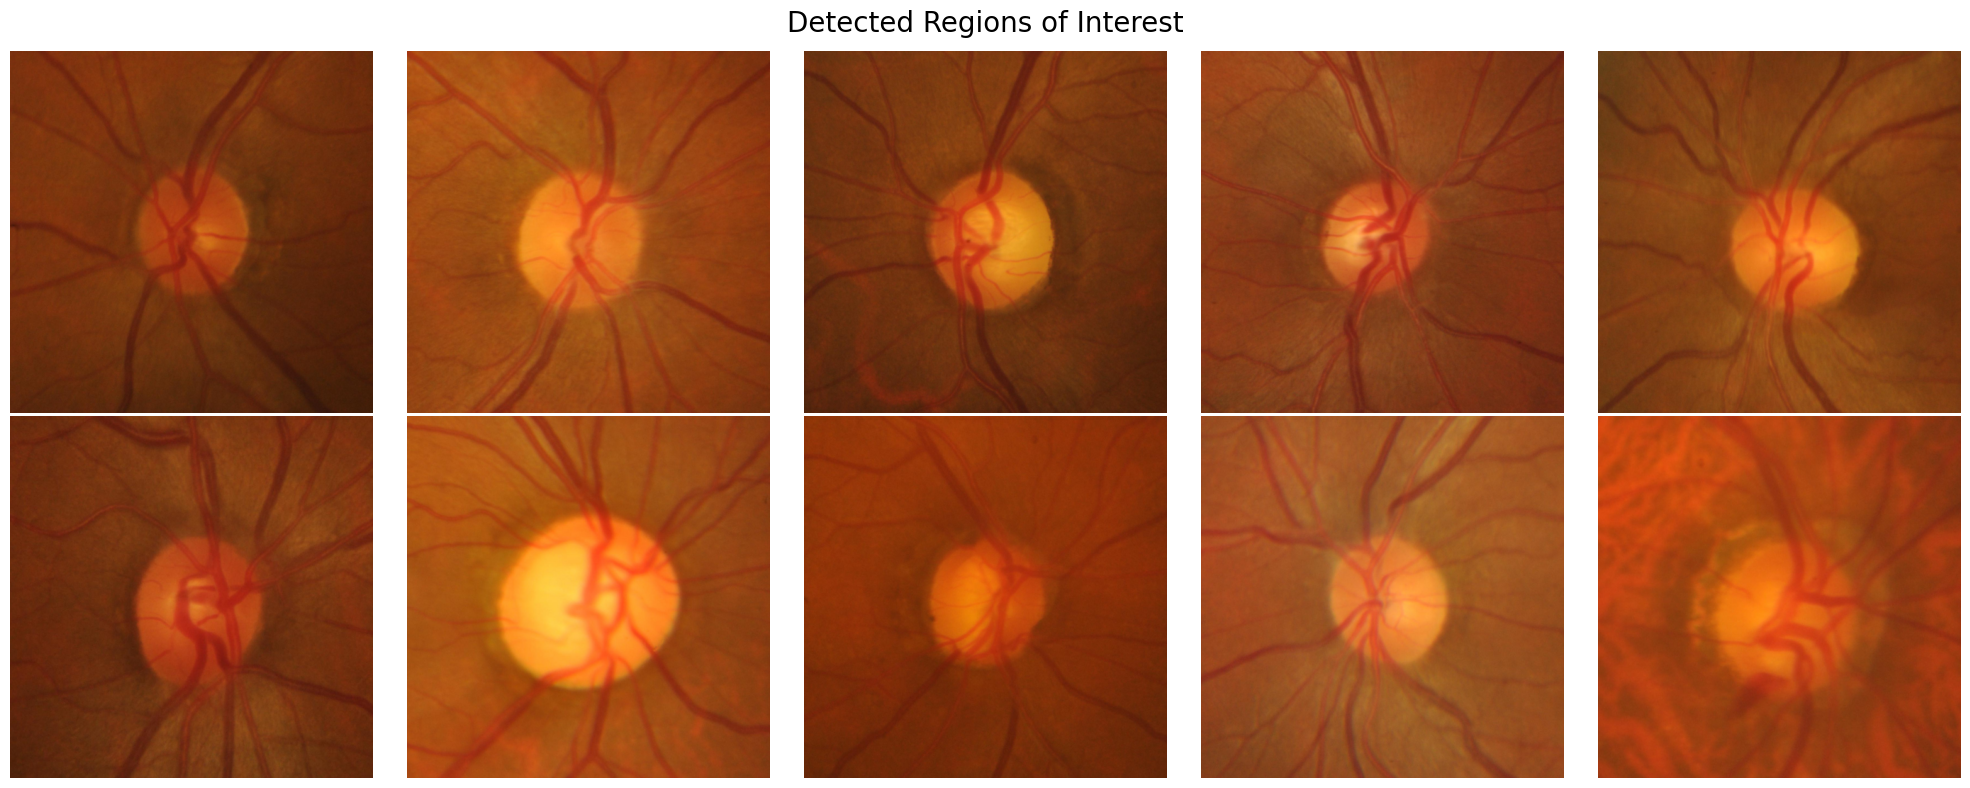

In [4]:
INPUT_SIZE = 512

transform = A.Compose([
    A.Resize(INPUT_SIZE, INPUT_SIZE, interpolation=cv.INTER_AREA),
    A.Normalize(mean=(0.9400, 0.6225, 0.3316), std=(0.1557, 0.1727, 0.1556)),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='coco', label_fields=['labels']))

dst_dir = os.path.join(images_dir, 'ROI')
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)

roi_image_paths = []
roi_images = []

for file in image_paths:
    preprocessed_img, _ = preprocess_centernet_input(file, mask=None)
    roi_image, _ = detect_roi(
        model, preprocessed_img, None, transform, INPUT_SIZE,
        device=DEVICE, small_margin=32, roi_size=512,
    )
    img_path = os.path.join(dst_dir, os.path.basename(file))
    cv.imwrite(img_path, cv.cvtColor(roi_image, cv.COLOR_RGB2BGR))
    roi_image_paths.append(img_path)
    roi_images.append(roi_image)

_, ax = plt.subplots(2, 5, figsize=(20, 8))
ax = ax.flatten()
for i, img in enumerate(roi_images):
    ax[i].imshow(img)
    ax[i].axis('off')
plt.suptitle('Detected Regions of Interest', fontsize=20)
plt.tight_layout()
plt.show()

### Step 2a): Dual Architecture Segmentation

In [5]:
images_dir = '../data/ORIGA/ROI/TrainImages'
masks_dir = '../data/ORIGA/ROI/TrainMasks'
images = [os.path.join(images_dir, f) for f in os.listdir(images_dir)]
masks = [os.path.join(masks_dir, f) for f in os.listdir(masks_dir)]

OD_THRESH = 0.2
OC_THRESH = 0.3
IMAGE_SIZE = 256

transform = A.Compose([
    A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE, interpolation=cv.INTER_AREA),
    A.Lambda(image=sharpen, p=1.0),
    A.Lambda(image=polar_transform, mask=polar_transform),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])
loader = load_dataset(images, masks, transform, batch_size=4, shuffle=True, num_workers=4)

ckpt = load_checkpoint('../models/polar/ref/dual.pth', map_location=DEVICE)
model = ckpt['model'].to(DEVICE).eval()

Loaded dataset with 325 samples in 82 batches.
=> Loading checkpoint: ../models/polar/ref/dual.pth


In [6]:
fp_oc, fn_oc, fp_od, fn_od = 0, 0, 0, 0

# Make predictions
model.eval()
with torch.no_grad():
    for i, (images, masks) in enumerate(loader):
        images = images.to(DEVICE).float()
        masks = masks.to(DEVICE).long()

        preds, *_ = predict(
            'dual', model, images, masks,
            od_thresh=OD_THRESH, oc_thresh=OC_THRESH,
            post_process_fn=postprocess,
        )
        met = get_metrics(masks, preds, [[1, 2], [2]])

        fp_oc += met['fp_OC']
        fn_oc += met['fn_OC']
        fp_od += met['fp_OD']
        fn_od += met['fn_OD']

pd.DataFrame({
    'FP': [fp_od, fp_oc],
    'FN': [fn_od, fn_oc],
}, index=['OD', 'OC'])

FP      FN
OD  223910   55351
OC  328623  163151

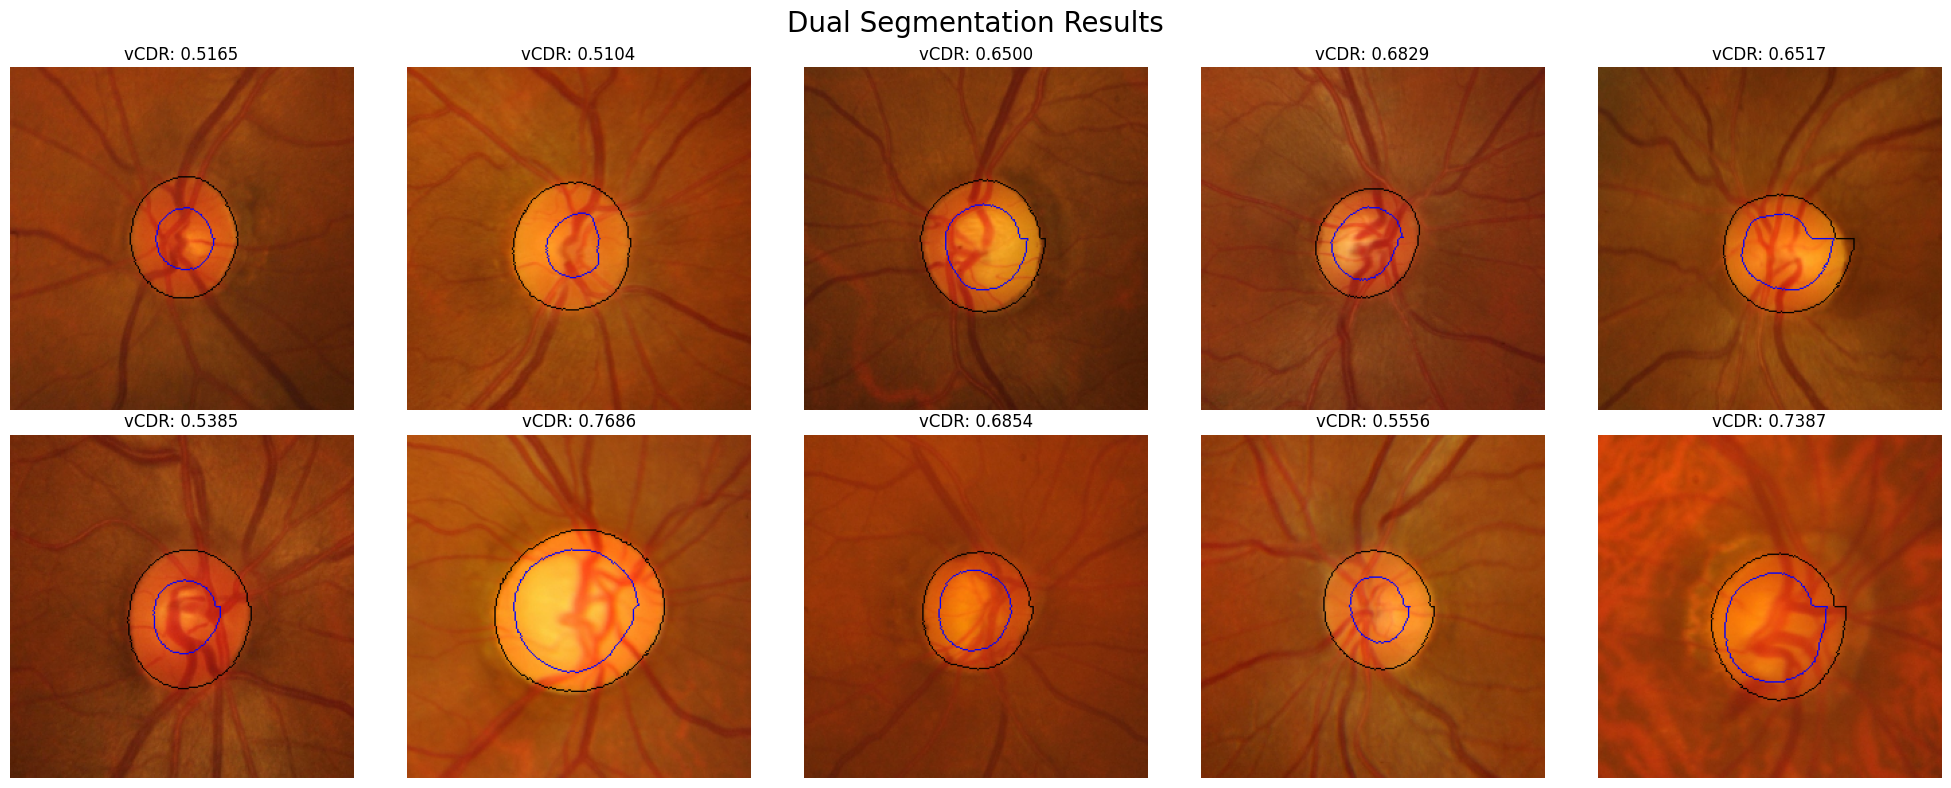

In [7]:
results = []
save_dir = '../data/ImagesForSegmentation/DualArchitectureSegmentation'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

with torch.no_grad():
    for i, img_path in enumerate(roi_image_paths):
        img = cv.imread(img_path, cv.IMREAD_COLOR)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        input_img = transform(image=img)['image']
        input_img = input_img.unsqueeze(0).to(DEVICE).float()

        pred, *_ = predict(
            'dual', model, input_img, None,
            od_thresh=OD_THRESH, oc_thresh=OC_THRESH,
            post_process_fn=postprocess,
        )
        pred = pred.cpu().numpy()
        pred = polar_to_cartesian(pred)[0]

        vcdr = calculate_vCDR(pred)
        contours = get_contour_image(img, pred, od_oc_colors=[(0, 0, 0), (0, 0, 255)])
        results.append((contours, vcdr))

_, ax = plt.subplots(2, 5, figsize=(20, 8))
ax = ax.flatten()
for i, (img, vcdr) in enumerate(results):
    ax[i].imshow(img)
    ax[i].set_title(f'vCDR: {vcdr:.4f}')
    ax[i].axis('off')
plt.suptitle('Dual Segmentation Results', fontsize=20)
plt.tight_layout()
plt.show()

In [ ]:
for i, (img, vcdr) in enumerate(results):
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.title(f'vCDR: {vcdr:.4f}')
    plt.tight_layout()
    plt.savefig(f'{save_dir}/{os.path.basename(roi_image_paths[i])}')

### Step 2b): Cascade Architecture Segmentation

In [9]:
ckpt = load_checkpoint('../models/polar/ref/binary.pth', map_location=DEVICE)
binary_model = ckpt['model'].to(DEVICE).eval()

ckpt = load_checkpoint('../models/polar/ref/cascade.pth', map_location=DEVICE)
model = ckpt['model'].to(DEVICE).eval()

=> Loading checkpoint: ../models/polar/ref/binary.pth
=> Loading checkpoint: ../models/polar/ref/cascade.pth


In [10]:
thresh = 0.5
fp_oc, fn_oc, fp_od, fn_od = 0, 0, 0, 0

# Make predictions
model.eval()
binary_model.eval()
with torch.no_grad():
    for i, (images, masks) in enumerate(loader):
        images = images.to(DEVICE).float()
        masks = masks.to(DEVICE).long()

        preds, *_ = predict(
            'cascade', model, images, masks,
            base_model=binary_model,
            od_thresh=OD_THRESH, oc_thresh=OC_THRESH,
            inter_process_fn=interprocess, post_process_fn=postprocess,
        )
        met = get_metrics(masks, preds, [[1, 2], [2]])

        fp_oc += met['fp_OC']
        fn_oc += met['fn_OC']
        fp_od += met['fp_OD']
        fn_od += met['fn_OD']

pd.DataFrame({
    'FP': [fp_od, fp_oc],
    'FN': [fn_od, fn_oc],
}, index=['OD', 'OC'])

FP      FN
OD  238783   59826
OC  517097  117100

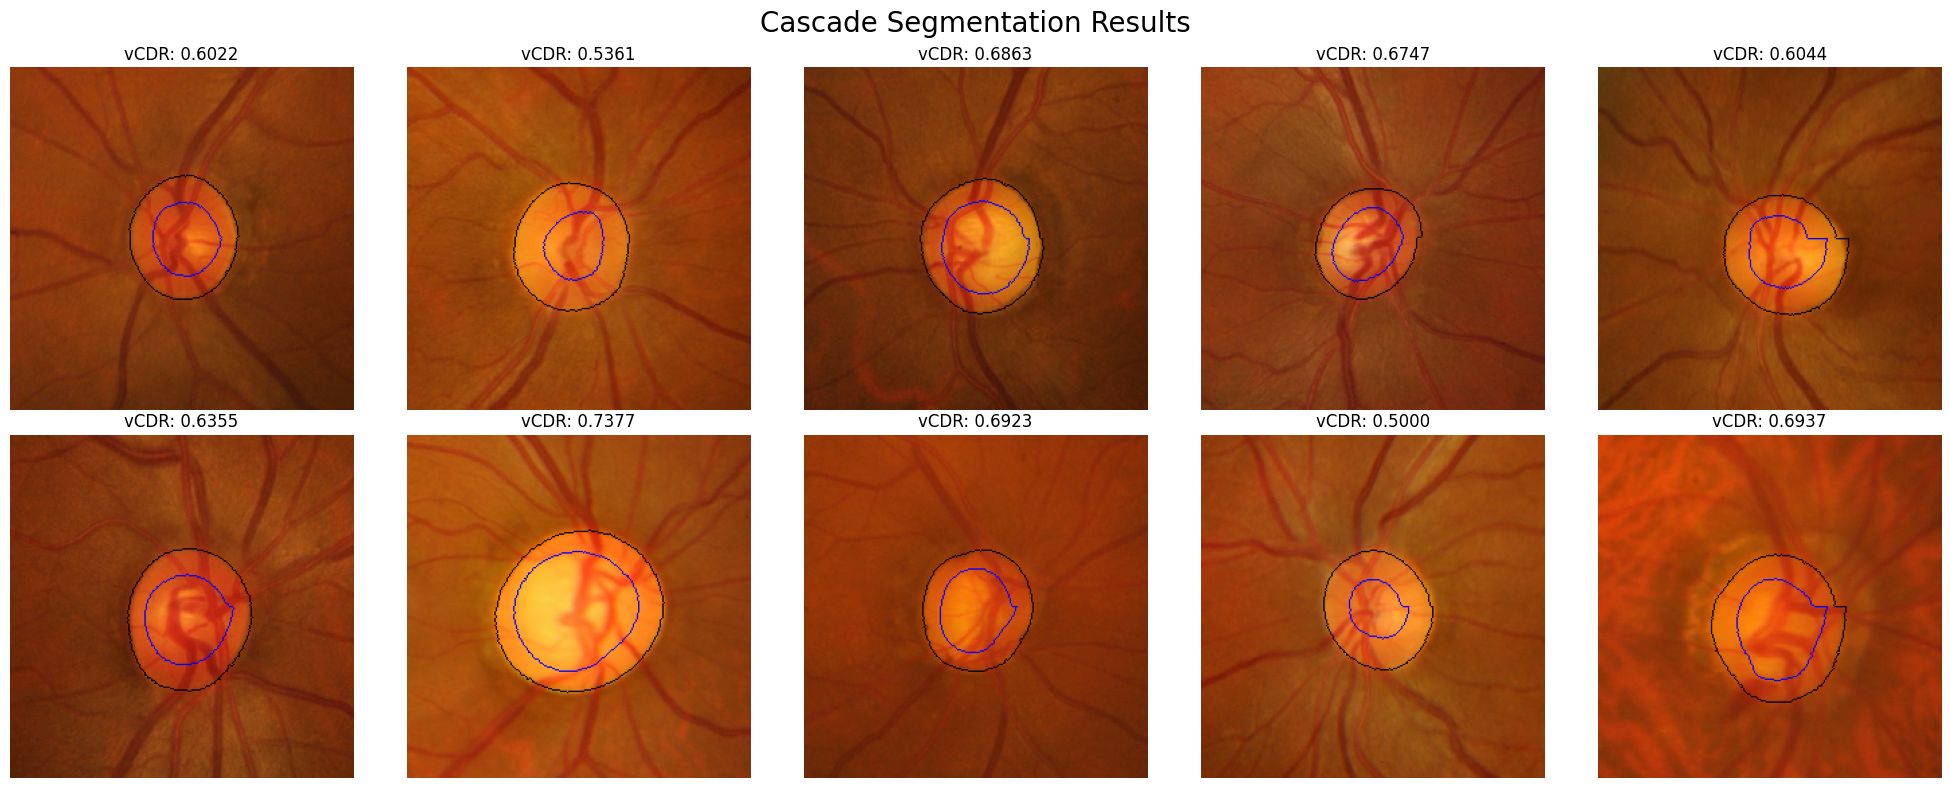

In [11]:
preds = []
save_dir = '../data/ImagesForSegmentation/CascadeArchitectureSegmentation'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

model.eval()
binary_model.eval()
with torch.no_grad():
    for i, image in enumerate(roi_image_paths):
        img = cv.imread(image, cv.IMREAD_COLOR)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        input_img = transform(image=img)['image']
        input_img = input_img.unsqueeze(0).to(DEVICE).float()

        pred, *_ = predict(
            'cascade', model, input_img, None,
            base_model=binary_model,
            od_thresh=OD_THRESH, oc_thresh=OC_THRESH,
            inter_process_fn=interprocess, post_process_fn=postprocess,
        )
        pred = pred.cpu().numpy()
        pred = polar_to_cartesian(pred)[0]

        vcdr = calculate_vCDR(pred)
        contours = get_contour_image(img, pred, od_oc_colors=[(0, 0, 0), (0, 0, 255)])
        preds.append((contours, vcdr))
        
_, ax = plt.subplots(2, 5, figsize=(20, 8))
ax = ax.flatten()
for i, (img, vcdr) in enumerate(preds):
    ax[i].imshow(img)
    ax[i].set_title(f'vCDR: {vcdr:.4f}')
    ax[i].axis('off')
plt.suptitle('Cascade Segmentation Results', fontsize=20)
plt.tight_layout()

In [ ]:
for i, (img, vcdr) in enumerate(preds):
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.title(f'vCDR: {vcdr:.4f}')
    plt.tight_layout()
    plt.savefig(f'{save_dir}/{os.path.basename(roi_image_paths[i])}')